In [14]:
import tarfile
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.optimize import curve_fit
import matplotlib.ticker as mticker
# Funzione di fit (es. lineare)
def linear_fit(x, a, b):
    return a * x + b

# Liste per i dati del fit
y_final_values = []
divisor_values = []

# List of archive paths
archive_paths = [
    "/home/dcarbone/catene/test/compressed_archive_N_500.tar.gz"
]

# Directory principale per salvare i PDF
main_output_dir = "./plots"

for archive_path in archive_paths:
    # Estrai il valore di N dal percorso dell'archivio
    match = re.search(r'compressed_archive_N_(\d+)', archive_path)
    if match:
        N = match.group(1)
        output_dir = os.path.join(main_output_dir, f"N_{N}")  # Crea una cartella basata su N
    else:
        N = "Unknown"
        output_dir = os.path.join(main_output_dir, "Unknown_N")  # Cartella generica se N non trovato

    os.makedirs(output_dir, exist_ok=True)  # Crea la cartella per questo valore di N

    # Liste per i dati dei plot finali
    all_df_data = []
    all_integral_df_data = []

    with tarfile.open(archive_path, 'r:gz') as archive:
        # List all .dat files in the archive
        files = [member.name for member in archive.getmembers() if member.name.endswith('.dat')]
        print(files)        
        for file_name in files:
            with archive.extractfile(file_name) as file:
                # Skip "Tr_1.dat"
                
                if "Tr_1.dat" in file_name:
                    continue

                # Extract Tr value
                match = re.search(r'Tr_([0-9]+(?:\.[0-9]+)?)', file_name)
                if match:
                    try:
                        Tr = float(match.group(1))  # Converte Tr in float
                    except ValueError:
                        print(f"Error: Couldn't convert Tr value '{match.group(1)}' to float in filename {file_name}, skipping...")
                        continue
                else:
                    print(f"Warning: Couldn't extract Tr from filename {file_name}, skipping...")
                    continue

                # Avoid division by zero
                if Tr <= 1:
                    print(f"Warning: Skipping file {file_name} due to Tr={Tr} <= 1")
                    continue

                # Load the data
                data = np.loadtxt(file)
                print(file_name)
                print("ciao")
                if data.shape[1] != 2:
                    print(f"Warning: {file_name} doesn't have exactly two columns, skipping...")
                    continue

                # Normalize data
                x = data[:, 0]
                y = data[:, 1]
                divisor = Tr - 1
                
                x_normalized = x / divisor*float(N)
                y_normalized = y / divisor*float(N)
                print(np.mean(x_normalized[-1:-20000:-1]))
                y_final_values.append(np.mean(y[-100:]))
                divisor_values.append(divisor/float(N))


                # Create DataFrames
                df = pd.DataFrame(x_normalized, columns=["x_normalized"])
                
                integral_df = pd.DataFrame(y_normalized, columns=["y_normalized"])

                # Salvare i dati per i plot finali
                all_df_data.append((file_name, df))
                all_integral_df_data.append((file_name, integral_df))

                # Plot df
                plt.figure(figsize=(8, 5))
                plt.plot(df, label="Normalized x")
                plt.xlabel("Index")
                plt.ylabel("Normalized x")
                plt.title(f"{file_name} - Normalized x")
                plt.legend()
                plt.grid()
                pdf_path_df = os.path.join(output_dir, f"N_{N}_Tr_{Tr}_df.pdf")  # Nominare il file come richiesto
                plt.savefig(pdf_path_df)
                plt.close()

                # Plot integral_df
                plt.figure(figsize=(8, 5))
                plt.plot(integral_df, label="Normalized y")
                plt.xlabel("Index")
                plt.ylabel("Normalized y")
                plt.title(f"{file_name} - Normalized y")
                plt.legend()
                plt.grid()
                pdf_path_integral = os.path.join(output_dir, f"N_{N}_Tr_{Tr}_integral_df.pdf")  # Nominare il file come richiesto
                plt.savefig(pdf_path_integral)
                plt.close()

                print(f"Saved plots for {file_name} to {pdf_path_df} and {pdf_path_integral}")
                   # Fit dei dati raccolti
    divisor_values = np.array(divisor_values)
    y_final_values = np.array(y_final_values)

    try:
    # Fit lineare
        popt, pcov = curve_fit(linear_fit, divisor_values, y_final_values)
        a, b = popt
        perr = np.sqrt(np.diag(pcov))  # Incertezze sui parametri

        print(f"Fit parameters: a={a} ± {perr[0]}, b={b} ± {perr[1]}")

        # Genera i dati del fit per il plot
        x_fit = np.linspace(min(divisor_values), max(divisor_values), 500)
        y_fit = linear_fit(x_fit, a, b)

        # Plot dei risultati del fit
        plt.figure(figsize=(8, 5))
        plt.errorbar(divisor_values, y_final_values, fmt='o', label="Data", color="blue")
        plt.plot(x_fit, y_fit, label=f"Fit: y = ({a:.2e} ± {perr[0]:.2e})x + ({b:.2e} ± {perr[1]:.2e})", color="red")

        # Configurazione asse y in notazione scientifica
        plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

        # Etichette e titolo
        plt.xlabel("DT/DX")
        plt.ylabel("Flux")
        plt.title("Fit of y[-1] vs Divisor with Uncertainties")
        plt.legend()
        plt.grid()

        # Salva il plot
        fit_plot_path = os.path.join(output_dir, f"N_{N}_fit_df.pdf")
        plt.savefig(fit_plot_path)
        plt.close()

        print(f"Saved fit plot to {fit_plot_path}")
    except Exception as e:
        print(f"Error during fitting: {e}")


    # Creazione dei plot finali
    # Plot con tutte le df
    plt.figure(figsize=(10, 6))
    for file_name, df in all_df_data:
        plt.plot(df, label=file_name)
    plt.xlabel("Index")
    plt.ylabel("Normalized x")
    plt.title(f"All Normalized x (df) - N={N}")
    plt.legend(fontsize=8)
    plt.grid()
    final_df_path = os.path.join(output_dir, f"all_N_{N}_df.pdf")
    plt.savefig(final_df_path)
    plt.close()
    print(f"Saved combined plot of all df to {final_df_path}")

    # Plot con tutte le integral_df
    plt.figure(figsize=(10, 6))
    for file_name, integral_df in all_integral_df_data:
        plt.plot(integral_df, label=file_name)
    plt.xlabel("Index")
    plt.ylabel("Normalized y")
    plt.title(f"All Normalized y (integral_df) - N={N}")
    plt.legend(fontsize=8)
    plt.grid()
    final_integral_df_path = os.path.join(output_dir, f"all_N_{N}_integral_df.pdf")
    plt.savefig(final_integral_df_path)
    plt.close()
    print(f"Saved combined plot of all integral_df to {final_integral_df_path}")

 

['test/ttcf_mil_N_500_Tr_11.dat', 'test/ttcf_mil_N_500_Tr_13.5.dat', 'test/ttcf_mil_N_500_Tr_16.dat', 'test/ttcf_mil_N_500_Tr_18.5.dat', 'test/ttcf_mil_N_500_Tr_6.dat', 'test/ttcf_mil_N_500_Tr_8.5.dat']
test/ttcf_mil_N_500_Tr_11.dat
ciao
0.0001823046961135555
Saved plots for test/ttcf_mil_N_500_Tr_11.dat to ./plots/N_500/N_500_Tr_11.0_df.pdf and ./plots/N_500/N_500_Tr_11.0_integral_df.pdf
test/ttcf_mil_N_500_Tr_13.5.dat
ciao
0.0003980460131530174
Saved plots for test/ttcf_mil_N_500_Tr_13.5.dat to ./plots/N_500/N_500_Tr_13.5_df.pdf and ./plots/N_500/N_500_Tr_13.5_integral_df.pdf
test/ttcf_mil_N_500_Tr_16.dat
ciao
0.0007771600719685982
Saved plots for test/ttcf_mil_N_500_Tr_16.dat to ./plots/N_500/N_500_Tr_16.0_df.pdf and ./plots/N_500/N_500_Tr_16.0_integral_df.pdf
test/ttcf_mil_N_500_Tr_18.5.dat
ciao
0.00031108060781667637
Saved plots for test/ttcf_mil_N_500_Tr_18.5.dat to ./plots/N_500/N_500_Tr_18.5_df.pdf and ./plots/N_500/N_500_Tr_18.5_integral_df.pdf
test/ttcf_mil_N_500_Tr_6.dat
cia

4001220
(10000, 166)


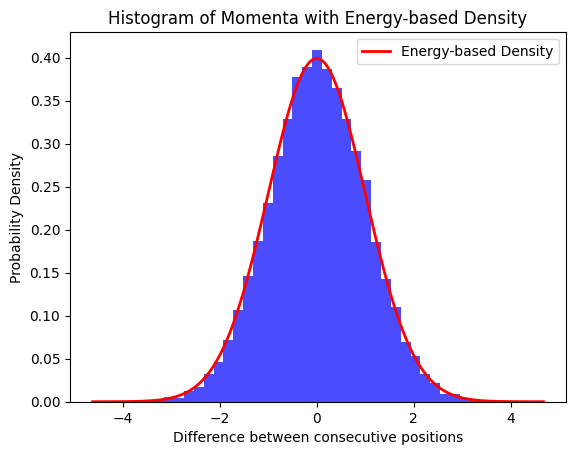

In [32]:
import numpy as np
import os
import random

def read_conditions(filename, num_condizioni, neq):
    # Verifica se il file esiste
    if not os.path.exists(filename):
        print("Errore nell'apertura del file per lettura!")
        return None
    
    # Dimensione di una condizione in byte
    dimensione_condizione = neq * np.dtype('float64').itemsize
    
    # Ottieni la dimensione totale del file
    file_size = os.path.getsize(filename)
    
    # Calcola il numero di condizioni nel file
    numero_condizioni_tot = file_size // dimensione_condizione

    print(numero_condizioni_tot)
    
    if num_condizioni > numero_condizioni_tot:
        print("Errore: il numero di condizioni richiesto eccede il numero di condizioni nel file.")
        return None

    # Inizializza il vettore per le condizioni
    condizioni = np.empty(num_condizioni * neq, dtype='float64')

    # Apri il file in modalità binaria
    with open(filename, 'rb') as inFile:
        for i in range(num_condizioni):
            # Seleziona un indice casuale
            indice_casuale = random.randint(0, numero_condizioni_tot - 1)
            
            # Calcola l'offset dell'indice
            offset = indice_casuale * dimensione_condizione
            
            # Posizionarsi nel file all'offset desiderato
            inFile.seek(offset)
            
            # Leggi la condizione e mettila nel vettore
            condition_data = np.fromfile(inFile, dtype='float64', count=neq)
            if condition_data.size != neq:
                print("Errore durante la lettura del file!")
                return None
            
            condizioni[i * neq : (i + 1) * neq] = condition_data

    return condizioni


filename = "condizioni_80.bin"
num_condizioni = 10000  # Numero di condizioni da leggere
N=80
dim=1
neq= (N+2)*2*dim + 2

condizioni = read_conditions(filename, num_condizioni, neq)
if condizioni is not None:
    cond_t=condizioni.reshape(num_condizioni,neq)[:,:neq]
print(cond_t.shape)


import numpy as np
import matplotlib.pyplot as plt

# Supponendo che `cond_t` sia già definito
# Estrai solo le colonne di `x` per ciascuna catena
x_values = cond_t[:, ::2]  # Prende solo le colonne alternate, che sono i valori `x`
p_values=np.concatenate(cond_t[:, 3:-2:2])
xival=np.concatenate(cond_t[:, -2:])
# Calcola le differenze tra valori successivi di `x` per ciascuna catena (prima dimensione)
diff_x_all = [np.diff(x_chain) for x_chain in x_values]

# Unisci tutte le differenze in un singolo array per l'istogramma
diff_x_all = np.concatenate(diff_x_all)

# Crea l'istogramma delle differenze
plt.hist(xival, bins=40, density=True, alpha=0.7, color='blue')

def energy(x, a, b):
    return x**2/2#(x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(p_values), max(p_values), 500)
density_vals = density(x_vals, 0, 1, 1)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Momenta with Energy-based Density')
plt.legend()
plt.show()

In [5]:
cond_t[0,62:]

array([31.,  0.])

<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:82: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:82: SyntaxWarning: invalid escape sequence '\D'
/var/tmp/ipykernel_65169/3128421086.py:80: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Comparison of Bulk Data with Theoretical $1/N$ and $1/\sqrt{N}$ Lines")
/var/tmp/ipykernel_65169/3128421086.py:82: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Values (Normalized by $\Delta T$)")


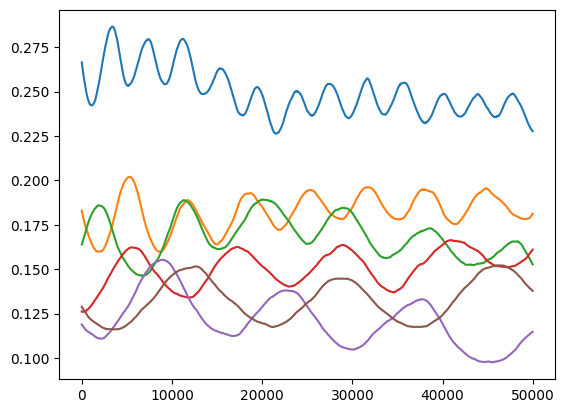

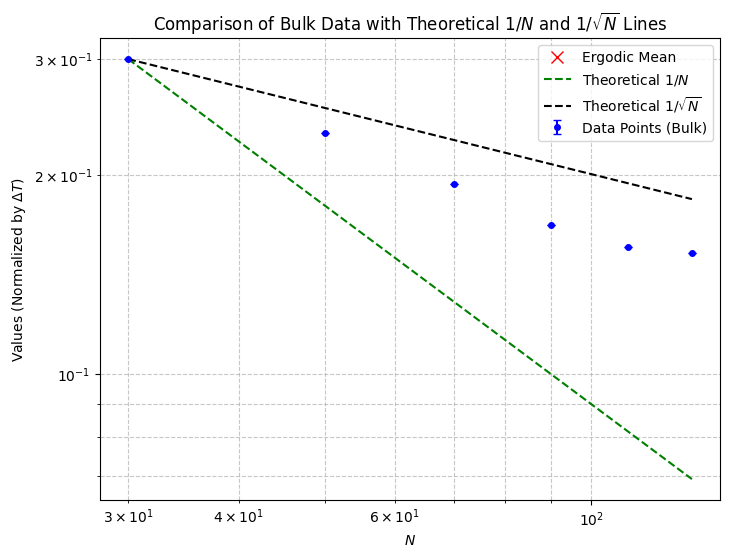

In [101]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the folders containing the .dat files
folder_path_tcf = "/home/dcarbone/catene/bulk/"
folder_path_erg = "/home/dcarbone/catene/ergodic/"

# 1. Process ttcf_mil_N_<number>_Tr_<deltaT>.dat files
file_list_tcf = [f for f in os.listdir(folder_path_tcf) if f.startswith("ttcf_mil_N_") and f.endswith(".dat")]
file_list_tcf.sort(key=lambda x: int(x.split("_")[3]))  # Sort by N

# Prepare data for the first set of files
N_values = []
last_col2_means = []
last_col2_semi_dispersion = []  # To store semidispersions

for file_name in file_list_tcf:
    if "Tr_128" not in file_name and "Tr_11" not in file_name and "N_250" not in file_name:
        file_path = os.path.join(folder_path_tcf, file_name)
        data = np.loadtxt(file_path)
        
        N = int(file_name.split("_")[3])  # Extract N
        deltaT = int(file_name.split("_")[-1].split(".")[0]) - 1  # Extract deltaT (last number before .dat) and subtract 1
        
        N_values.append(N)
        normalized_data = data[:, 1] / deltaT
        mean_value = np.max(normalized_data[:])  # Mean of last 100 points
        semi_dispersion = (np.max(normalized_data[-30000:]) - np.min(normalized_data[-10000:])) / 2  # Semidispersion
        plt.plot(data[10000:, 1] / deltaT)
        last_col2_means.append(mean_value)
        last_col2_semi_dispersion.append(semi_dispersion)
plt.show()
N_values = np.array(N_values)
last_col2_means = np.array(last_col2_means)
last_col2_semi_dispersion = np.array(last_col2_semi_dispersion)

# 2. Process ergodic_N_<number>_Tr_<deltaT>.dat files
file_list_erg = [f for f in os.listdir(folder_path_erg) if f.startswith("ergodic_N_") and f.endswith(".dat")]
file_list_erg.sort(key=lambda x: int(x.split("_")[2]))  # Sort by N

ergodic_N_values = []
ergodic_means = []

# for file_name in file_list_erg:
#     if "Tr_2" not in file_name and "Tr_11" not in file_name and "N_30" not in file_name and "N_500" not in file_name and "N_750" not in file_name and "N_1000" not in file_name:
#         file_path = os.path.join(folder_path_erg, file_name)
#         with open(file_path, 'r') as f:
#             line = f.readline().strip()  # Read the first line
#             ergodic_mean = float(line.split(":")[1].strip())  # Extract the numeric value after "Ergodic mean:"
        
#         N = int(file_name.split("_")[2])  # Extract N
#         deltaT = int(file_name.split("_")[-1].split(".")[0]) - 1  # Extract deltaT
#         ergodic_N_values.append(N)
#         ergodic_means.append(ergodic_mean / deltaT)  # Normalize by deltaT

ergodic_N_values = np.array(ergodic_N_values)
ergodic_means = np.array(ergodic_means)

# 3. Generate theoretical lines for comparison
inv_N = 1 / N_values
inv_sqrt_N = 1 / (N_values ** (1/3))
ref_line_invN = last_col2_means[0] * inv_N / inv_N[0]  # Scaled 1/N
ref_line_inv_sqrtN = last_col2_means[0] * inv_sqrt_N / inv_sqrt_N[0]  # Scaled 1/sqrt(N)

# 4. Plot in log-log scale with error bars (semidispersion)
plt.figure(figsize=(8, 6))

# Plot bulk data with error bars (semidispersion)
plt.errorbar(N_values, last_col2_means, yerr=last_col2_semi_dispersion*0, fmt='o', label="Data Points (Bulk)", markersize=4, color="b", capsize=3)

# Plot ergodic means
plt.loglog(ergodic_N_values, ergodic_means, 'x', label="Ergodic Mean", markersize=8, color="red")

# Add theoretical lines (optional)
plt.loglog(N_values, ref_line_invN, '--', label=r"Theoretical $1/N$", color="g")
plt.loglog(N_values, ref_line_inv_sqrtN, '--', label=r"Theoretical $1/\sqrt{N}$", color="black")

# Customize plot
plt.title("Comparison of Bulk Data with Theoretical $1/N$ and $1/\sqrt{N}$ Lines")
plt.xlabel(r"$N$")
plt.ylabel("Values (Normalized by $\Delta T$)")
plt.legend()
plt.grid(which="both", linestyle="--", alpha=0.7)
plt.show()


Slope: -0.4359 ± 0.0060
Intercept: -0.0003 ± 0.0003


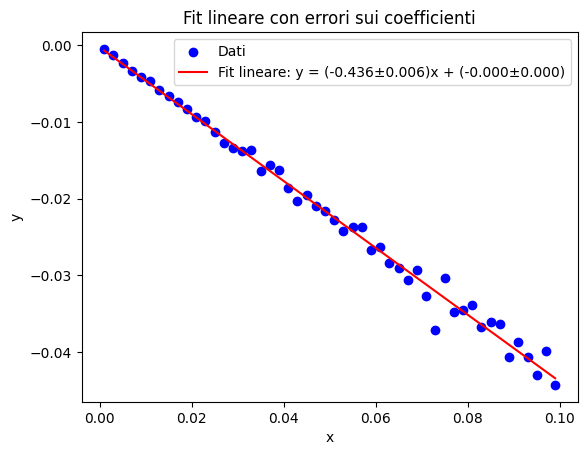

In [43]:
0.44*np.sqrt(8/3)

0.7185169912163989

<Axes: >

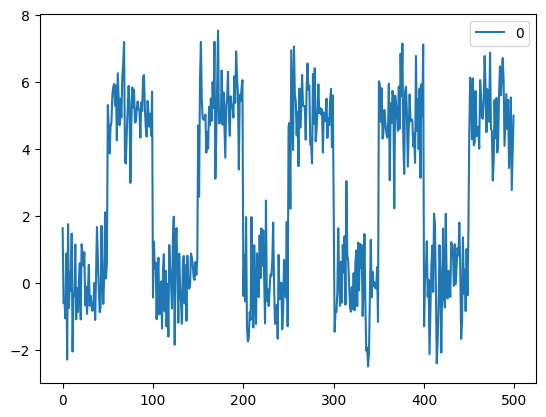

In [2]:
df.plot()